In [3]:
# python libraries
import mpld3
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    ConstantVectorSource,
    DiagramBuilder,
    PidController,
    Simulator,
    SymbolicVectorSystem,
    Variable,
    VectorLogSink,
    sin,
)

from manipulation import running_as_notebook
# from manipulation.exercises.grader import Grader
# from manipulation.exercises.robot.test_reflected_inertia import (
#     TestSimplePendulumWithGearbox,
# )
from manipulation.utils import RenderDiagram

# enable mpld3 notebook
if running_as_notebook:
    mpld3.enable_notebook()

In [ ]:
def pendulum_dynamics(x, u, p):
    q = x[0]
    qdot = x[1]
    tau = u[0]
    return [
        qdot,
        ((-p["m"] * p["g"] * p["l"] * sin(q) + tau) / (p["m"] * p["l"] ** 2)),
    ]

In [ ]:
context = system.CreateDefaultContext()
print(context)

In [ ]:
# Modify this function. you may not change the function name, inputs, or size of the output.


def pendulum_with_motor_dynamics(x, u, p):
    x[0]
    x[1]
    u[0]
    k= p["I_m"]+p["m"]*p["l"]**2/p["N"]**2 # I_motor+I_pendilum/N**2
    x_dot=x[1]

    x_double_dot = ( (-p["m"]*p["g"]*p["l"]* sin(x[0]))/p["N"]**2 + u[0]/p["N"] )*(k**(-1)) 
    
    return [x_dot, x_double_dot] 

In [ ]:
# Add motor and gearbox parameters
p = {
    "N": 160,
    "I_m": 3.46e-4,
    "m": 1.0,  # kg
    "g": 9.81,  # m / s^2
    "l": 0.5,  # m
}

In [ ]:
def BuildAndSimulate(q_d, pendulum_params, gains, visualize=False):
    # This defines the plant using the pendulum with motor dynamics.
    system = SymbolicVectorSystem(
        state=x,
        output=x,
        input=u,
        dynamics=pendulum_with_motor_dynamics(x, u, pendulum_params),
    )

    kp, ki, kd = gains

    builder = DiagramBuilder()

    # Add all the systems into the diagram
    builder.AddSystem(system) # what is a system exactly here?
    logger = builder.AddSystem(VectorLogSink(2))
    pid_controller = builder.AddSystem(PidController([kp], [ki], [kd]))
    desired_state = builder.AddSystem(ConstantVectorSource([q_d, 0.0]))

    # Connect the IO ports of the systems.
    builder.Connect(pid_controller.get_output_port(0), system.get_input_port(0))
    builder.Connect(system.get_output_port(0), logger.get_input_port(0))
    builder.Connect(system.get_output_port(0), pid_controller.get_input_port(0))
    builder.Connect(desired_state.get_output_port(0), pid_controller.get_input_port(1))

    diagram = builder.Build()
    diagram.set_name("diagram")

    # Plot the diagram if visualize is true.
    if visualize and running_as_notebook:
        RenderDiagram(diagram, max_depth=1)

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # The simulator has three states since the plant has 2, and the PID controller
    # keeps an additional state for the integral term. We set all of them to zero - doubt what is the menaning of additional state for the integral term?
    # initialization.
    context.SetContinuousState([0.0, 0.0, 0.0])

    return simulator, logger.FindLog(context)

In [4]:
# Question 2

In [6]:
import numpy as np
from pydrake.all import StartMeshcat, namedview

# from manipulation.exercises.grader import Grader
# from manipulation.exercises.robot.test_hardware_station_io import TestHardwareStationIO
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import RenderDiagram

In [7]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [13]:
meshcat2=StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [16]:
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""
scenario = LoadScenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat=meshcat)
context = station.CreateDefaultContext()
print(context)
station.GetInputPort("iiwa.position").FixValue(context, np.zeros(7))
station.GetInputPort("iiwa.torque").FixValue(context, np.zeros(7))
station.GetInputPort("wsg.position").FixValue(context, [0.1])
station.ForcedPublish(context)

::station Context (of a Diagram)
---------------------------------
14 total continuous states
36 total discrete states in 7 groups
1 total abstract states
640 total numeric parameters in 86 groups
19 total abstract parameters

::station::plant Context
-------------------------
Time: 0
States:
  1 discrete state groups with
     18 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0     0     0     0     0
  1 abstract states

Parameters:
  85 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     0 parameters
       
     0 parameters
       
     0 parameters
       
     1 parameters
       7.171875000000001e-05
     1 parameters
       160
     1 parameters
       0.0

In [15]:
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""
scenario = LoadScenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat=meshcat2)
context = station.CreateDefaultContext()
station.ForcedPublish(context)

In [18]:
station_context = station.CreateDefaultContext()
plant = station.GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(station_context)
print(plant_context)

::station::plant Context
-------------------------
Time: 0
States:
  1 discrete state groups with
     18 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0     0     0     0     0
  1 abstract states

Parameters:
  85 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     0 parameters
       
     0 parameters
       
     0 parameters
       
     1 parameters
       7.171875000000001e-05
     1 parameters
       160
     1 parameters
       0.0001737109
     1 parameters
       160
     1 parameters
       0.0001266406
     1 parameters
       160
     1 parameters
       7.09765e-05
     1 parameters
       160
     1 parameters
       5.4375e-05
     1 parameters
 

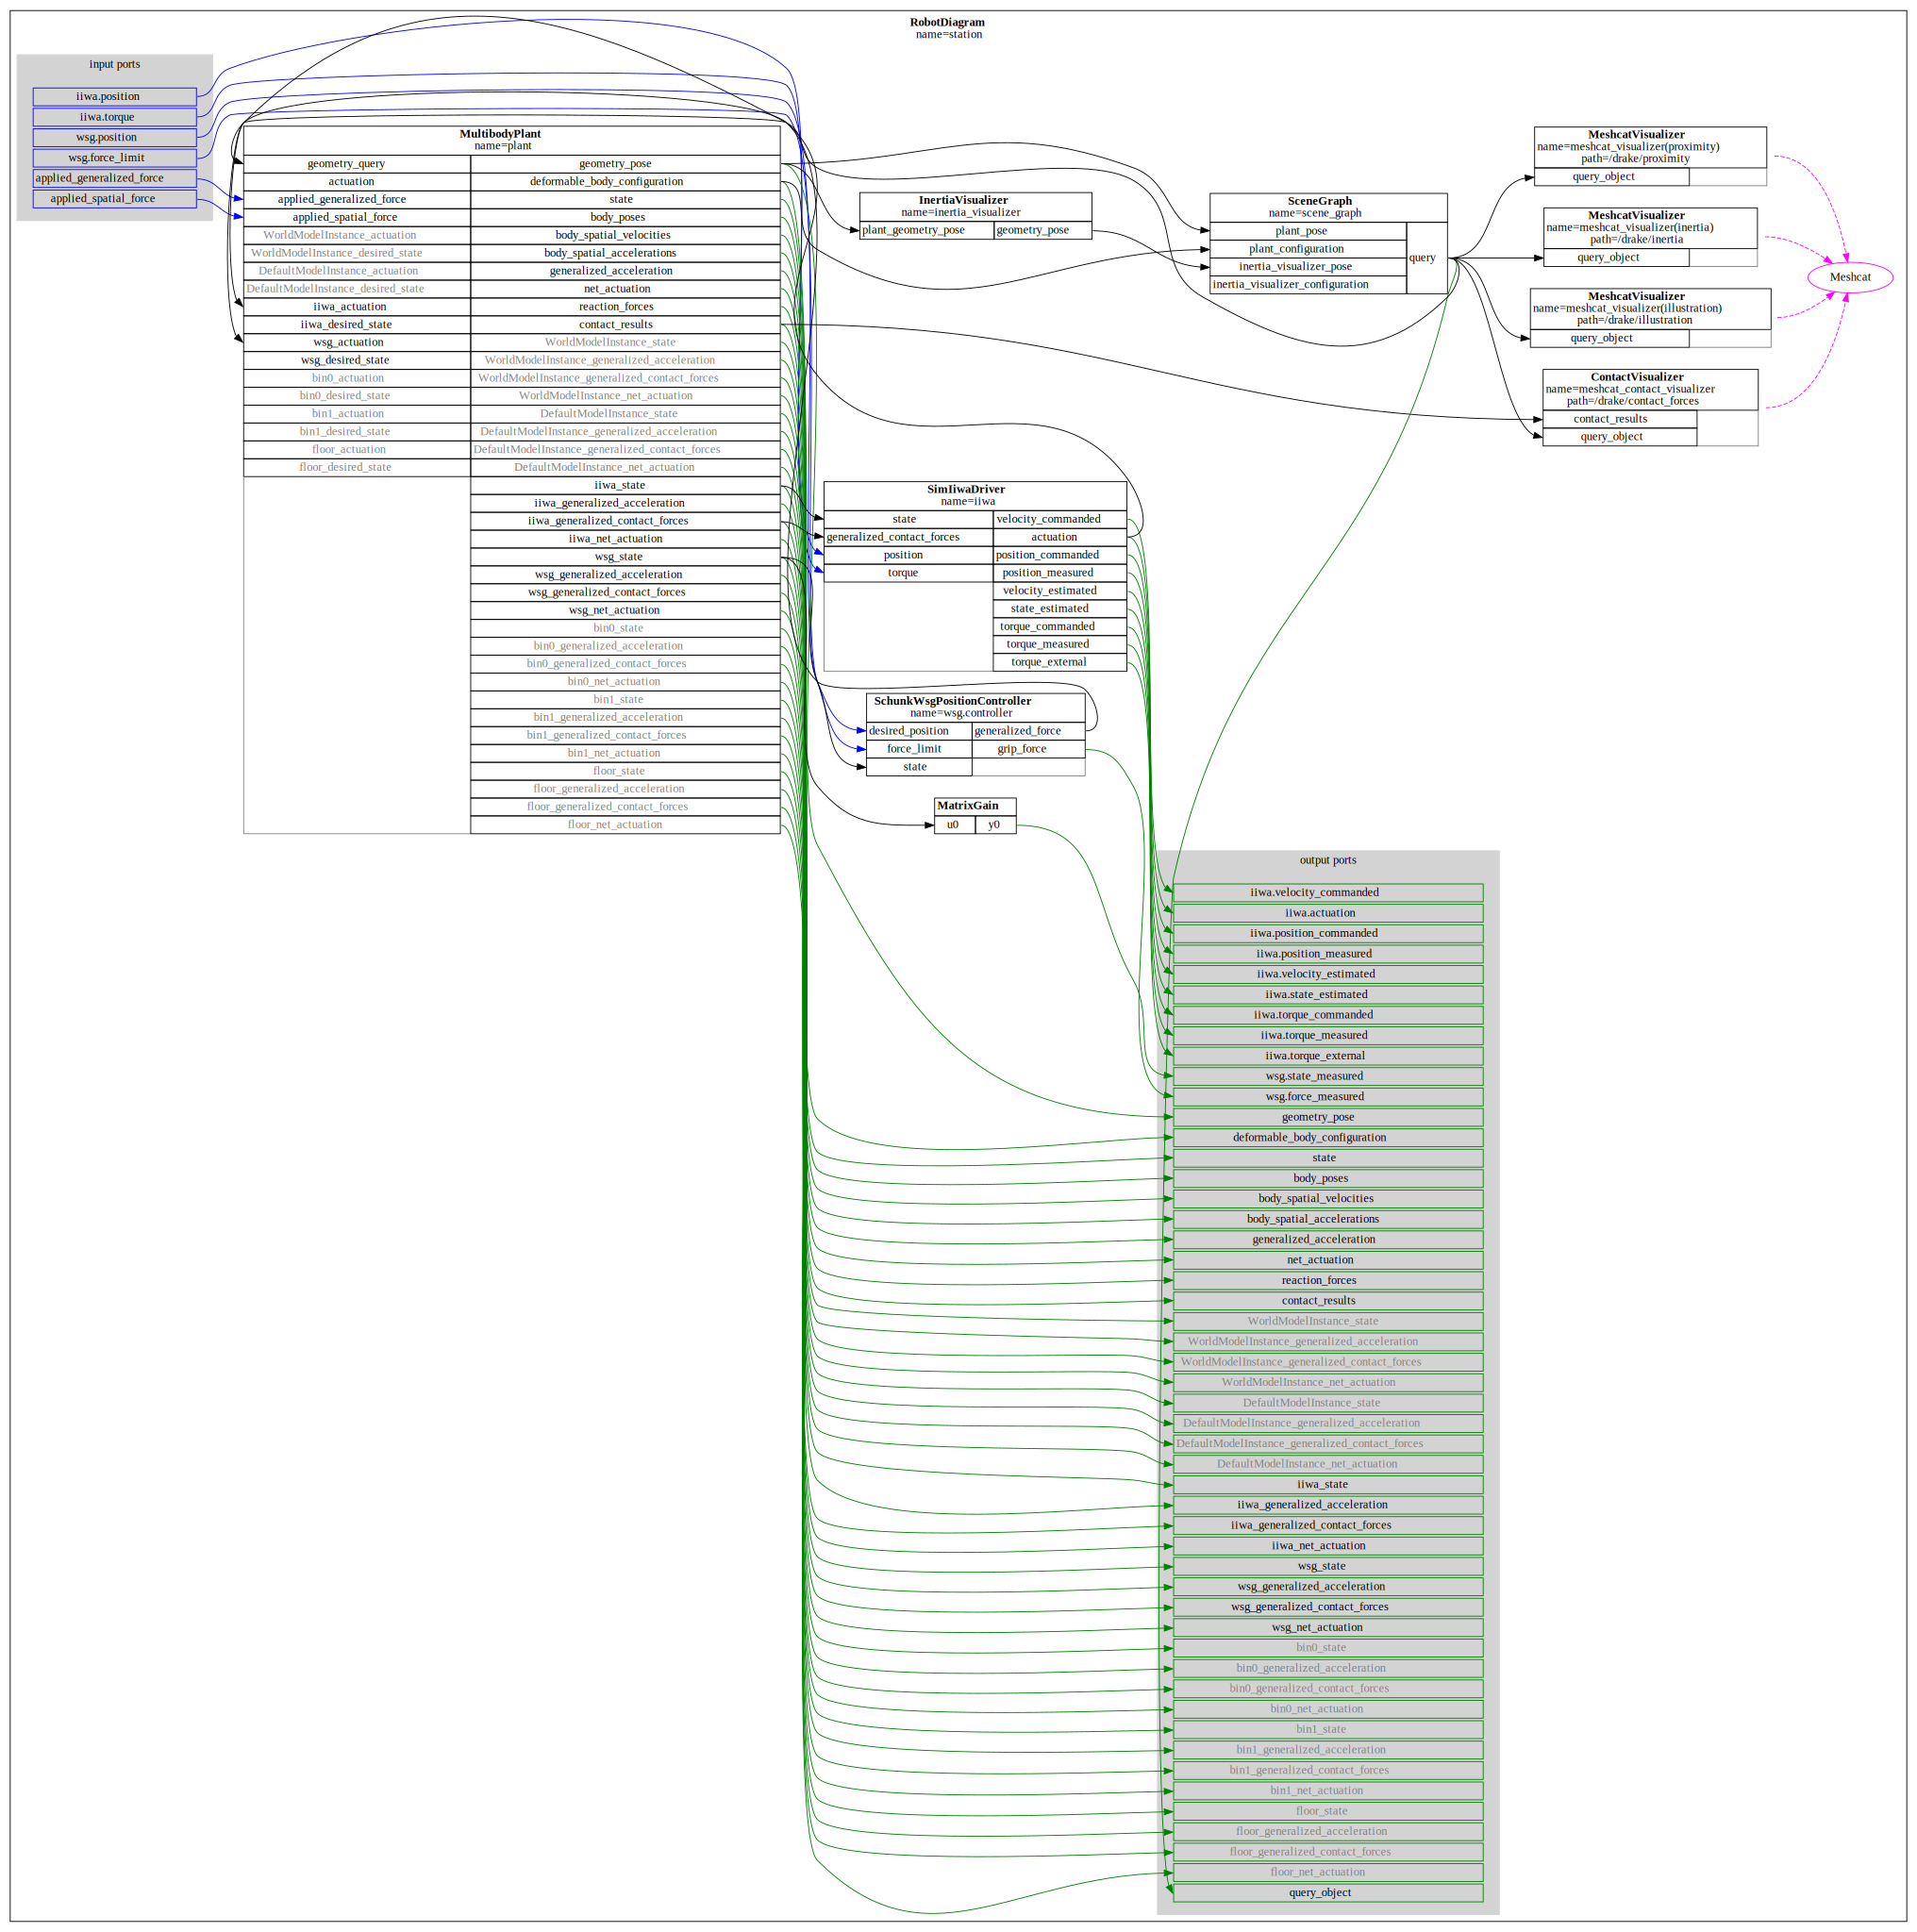

In [20]:
RenderDiagram(station, max_depth=1)

In [23]:
# provide initial states
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
iiwa = plant.GetModelInstanceByName("iiwa")
# set the joint positions of the kuka arm
plant.SetPositions(plant_context, iiwa, q0)
# examine the output port
station.GetOutputPort("iiwa.position_measured").Eval(station_context)

array([-1.57,  0.1 ,  0.  , -1.2 ,  0.  ,  1.6 ,  0.  ])

In [24]:
print(plant.GetPositions(plant_context, iiwa))

[-1.57  0.1   0.   -1.2   0.    1.6   0.  ]


In [25]:
plant.SetVelocities(
    plant_context,
    iiwa,
    np.zeros(
        7,
    ),
)

In [27]:
def get_velocity(station, station_context):

    plant = station.GetSubsystemByName("plant")
    iiwa = plant.GetModelInstanceByName("iiwa")
    plant_context = plant.GetMyContextFromRoot(station_context)

    velocity_estimated =  station.GetOutputPort("iiwa.velocity_estimated").Eval(station_context)
    return velocity_estimated

In [28]:
print(get_velocity(station, station_context))

[0. 0. 0. 0. 0. 0. 0.]


In [29]:
station.GetInputPort("iiwa.position").FixValue(station_context, np.zeros(7))
station.GetInputPort("iiwa.torque").FixValue(
    station_context,
    np.zeros(
        7,
    ),
)
tau_no_ff = station.GetOutputPort("iiwa.torque_commanded").Eval(station_context)
print(
    "feedforward torque: {}".format(
        np.zeros(
            7,
        )
    )
)
print("commanded torque with no feedforward torque:{}".format(tau_no_ff))

feedforward torque: [0. 0. 0. 0. 0. 0. 0.]
commanded torque with no feedforward torque:[ 176. -176.  110.  110.  110.  -40.  -40.]


In [30]:
tau_ff = np.linspace(3.1, 3.7, 7)
print("feedforward torque: {}".format(tau_ff))
station.GetInputPort("iiwa.torque").FixValue(station_context, tau_ff)
torque_commanded = station.GetOutputPort("iiwa.torque_commanded").Eval(station_context)
print("the commanded torque: {}".format(torque_commanded))

feedforward torque: [3.1 3.2 3.3 3.4 3.5 3.6 3.7]
the commanded torque: [ 176. -176.  110.  110.  110.  -40.  -40.]


In [ ]:
# Question: You must answer correctly why there is a difference between feed-forward torque and commanded torque.
# command  torque is to attaion specific velocity and position- to get it we get input torque plus output torque to get command toqrque

In [ ]:
# So far we have not looked into the outputs of simulated camera sensors. 
# Fortunately, accessing the camera data can be done in an almost exactly the same way as we have shown above.
# We will get to it soon!

In [ ]:
# question 3 Direct joint control

In [31]:
import numpy as np
from pydrake.all import DiagramBuilder, LeafSystem, Simulator, StartMeshcat

from manipulation import running_as_notebook
# from manipulation.exercises.grader import Grader
# from manipulation.exercises.robot.test_direct_joint_control import (
#     TestDirectJointControl,
# )
from manipulation.station import LoadScenario, MakeHardwareStation

In [32]:
# Start the visualizer.
meshcat = StartMeshcat()
meshcat.Set2dRenderMode(xmin=-0.25, xmax=1.5, ymin=-0.1, ymax=1.3)

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [33]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://manipulation/planar_iiwa14_no_collision.urdf
    default_joint_positions:
        iiwa_joint_2: [0.1]
        iiwa_joint_4: [-1.2]
        iiwa_joint_6: [1.6]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
model_drivers:
    iiwa: !IiwaDriver
        control_mode: position_only
        desired_kp_gains: [500, 500, 200]
"""
scenario = LoadScenario(data=scenario_data)

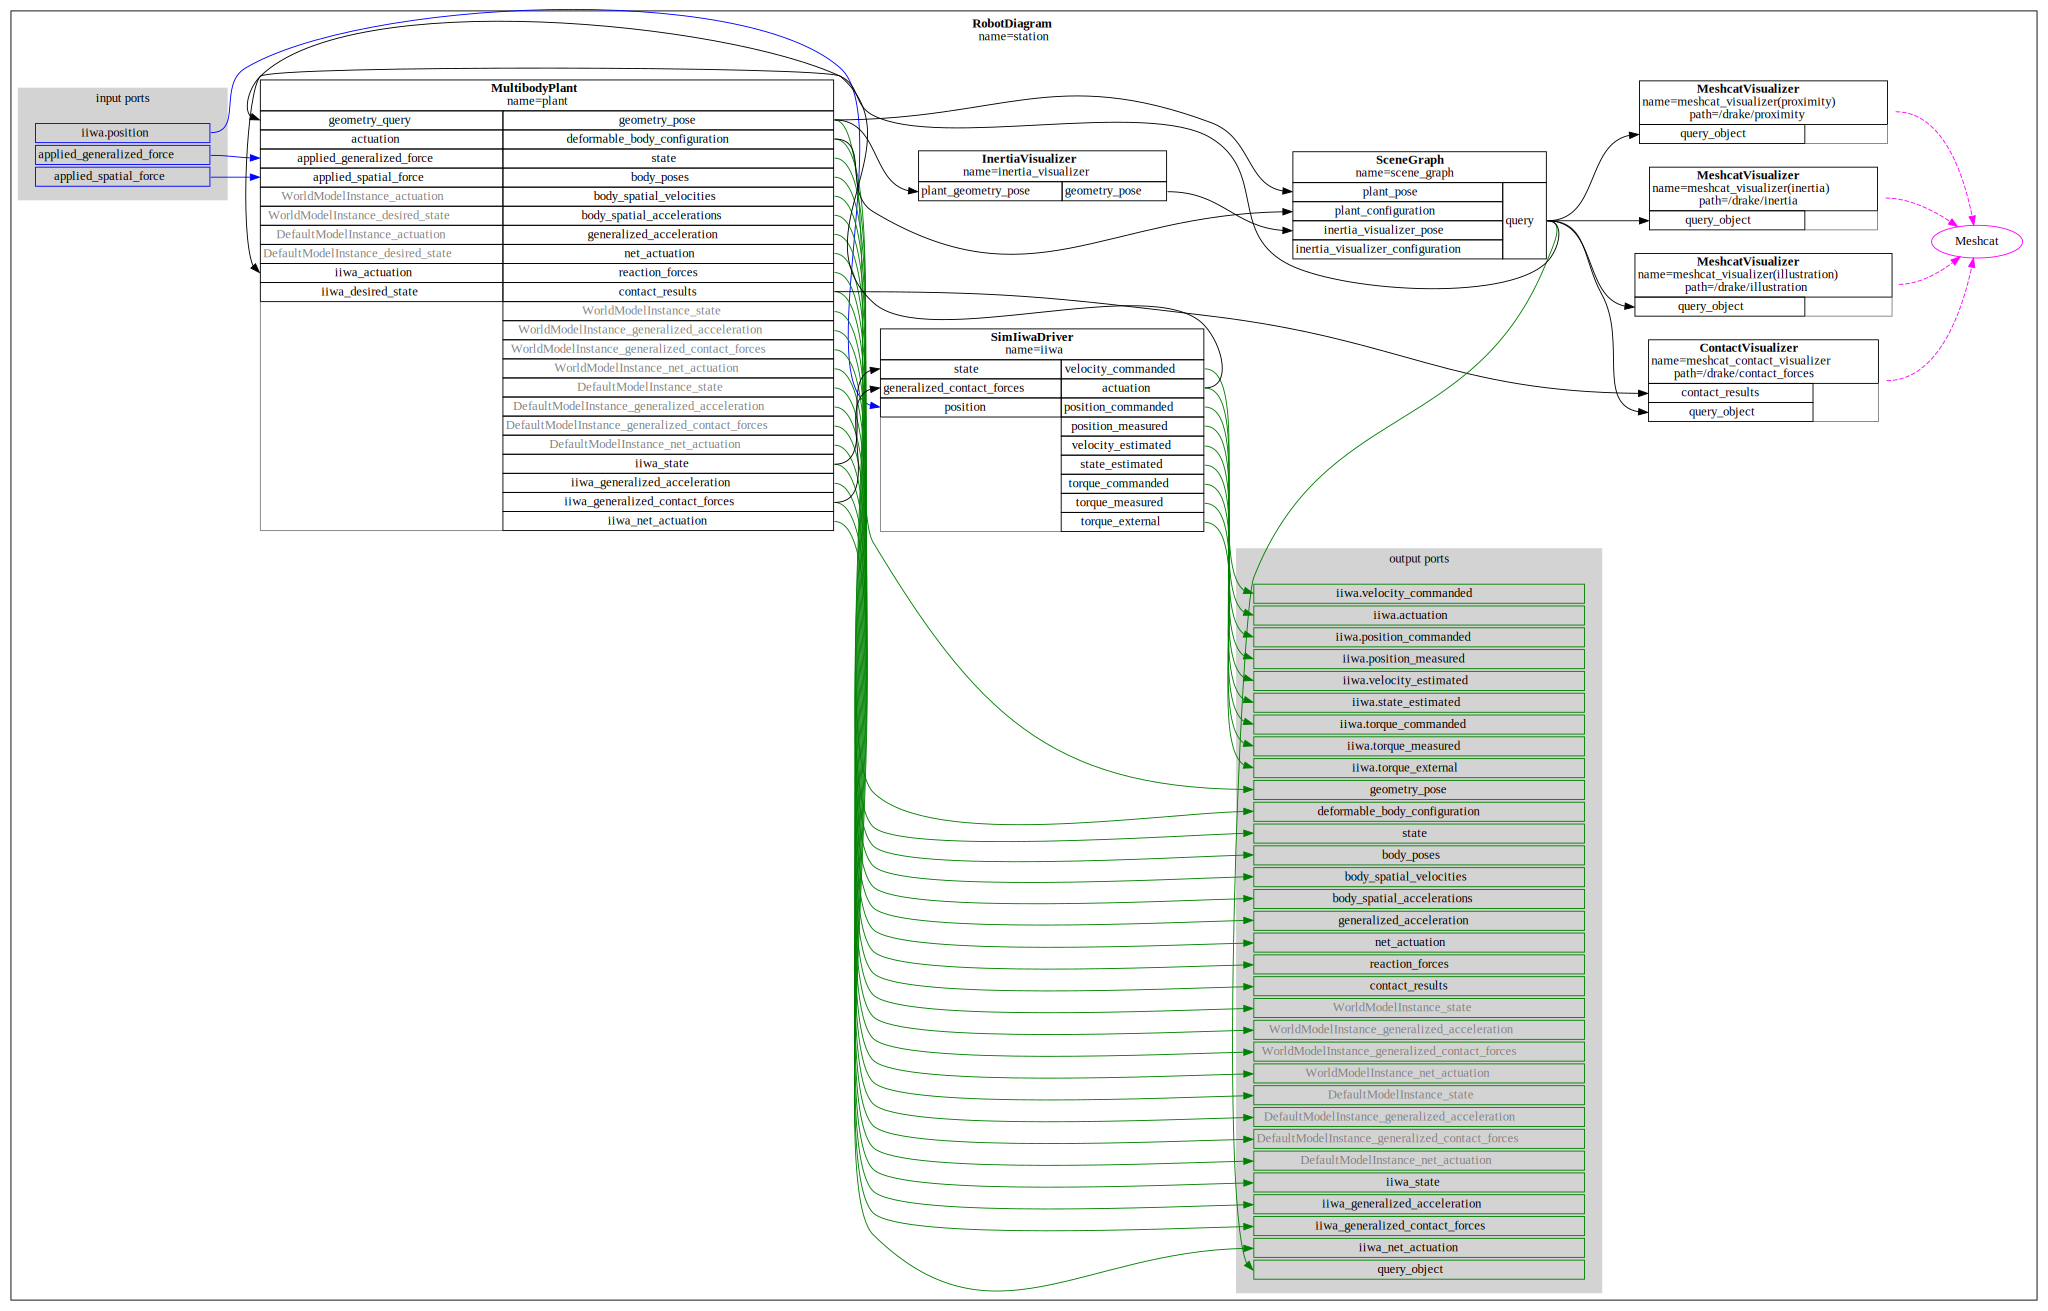

In [35]:
builder = DiagramBuilder()

station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
RenderDiagram(station, max_depth=1)

In [38]:
class CommandInputSystem(LeafSystem):
    def __init__(self, interactive, q_cmd):
        LeafSystem.__init__(self)

        self._interactive = interactive
        self._q_cmd = q_cmd

        # Declare input and output ports.
        self._q_current_input = self.DeclareVectorInputPort(name="q_current", size=3)
        self.DeclareVectorOutputPort(name="q_cmd", size=3, calc=self.CalcOutput)

    def CalcOutput(self, context, output):
        # Read the input port.
        q_current = self._q_current_input.Eval(context)

        if self._interactive and running_as_notebook and self._q_cmd is None:
            q_cmd = q_current.copy()
            q_cmd[0] = float(
                input(
                    f"Please enter value for first movable joint (current value: {q_current[0]:.3f})"
                )
            )
            q_cmd[1] = float(
                input(
                    f"Please enter value for second movable joint (current value: {q_current[1]:.3f})"
                )
            )
            q_cmd[2] = input(
                f"Please enter value for third movable joint (current value: {q_current[2]:.3f})"
            )
            self._q_cmd = q_cmd
        else:
            q_cmd = self._q_cmd

        if q_cmd is None:
            q_cmd = np.zeros(3)

        # Write to the output port.
        output.SetFromVector(q_cmd)

    def reset(self):
        self._q_cmd = None


def teleop_2d_direct(interactive=False, q_cmd=None):
    """
    Joint position control of the Kuka iiwa robot, without using teleop sliders or differential IK.

    Args:
        interactive (bool): If True, function will query the user to manually set the desired joint positions
            while running the simulator. Otherwise, function will use "q_cmd" as the target joint position.
        q_cmd (np.ndarray, list): Shape (3,). Desired positions of the three movable joints on the 2D robot.
            "q_cmd" cannot be None if "interactive" is set to False.
    """
    assert (
        not interactive and q_cmd is not None
    ) or interactive, 'Variable "q_cmd" must not be None if the function is run in non-interactive mode'

    builder = DiagramBuilder()

    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))

    command_input_system = builder.AddSystem(CommandInputSystem(interactive, q_cmd))

    #######################################################################
    # Your code here
    builder.Connect(command_input_system.get_output_port(0), station.get_input_port(0))
    # (connect the input and output port of `command_input_system` to the `station` ports)
    # (hint: what output ports does the `station` instance have available?)

    #######################################################################

    diagram = builder.Build()

    #######################################################################
    # Your code here. We wish to construct the following:
    # 1. simulator
    # 2. context: The context variable is set to the context owned by the simulator. What public member function can we use to get this context? See https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_simulator.html
    # 3. station_context: We want a context for the station that is retrieved from the context owned by the simulator. See "Subcontext access" at https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_system.html

    simulator = None
    context = None
    station_context = None
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    station_context = station.CreateDefaultContext()
    #######################################################################

    if simulator is None:
        print("You must set the simulator variable above")
        return station, station_context

    simulator.set_target_realtime_rate(1.0 if interactive else 0)
    meshcat.AddButton("Stop Simulation")
    while meshcat.GetButtonClicks("Stop Simulation") < 1:
        # Command the desired positions for 2s while simulating.
        simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)

        q_current_cmd = station.GetOutputPort("iiwa.position_commanded").Eval(
            station_context
        )
        print(f"Current commanded joint angles: {q_current_cmd}")

        if not interactive or not running_as_notebook:
            break
        else:
            # Reset the input system so that it asks for user input.
            command_input_system.reset()

    meshcat.DeleteButton("Stop Simulation")

    return station, station_context

In [39]:
teleop_2d_direct(interactive=True)

RuntimeError: InputPort::Eval(): required InputPort[0] (q_current) of System ::_::__main__.CommandInputSystem@000000003dd82520 (__main__.CommandInputSystem) is not connected

In [ ]:
# question 4 P, PD, PID controller compariosn for IIWA14

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    BasicVector,
    Context,
    Diagram,
    DiagramBuilder,
    LeafSystem,
    MeshcatVisualizer,
    ModelInstanceIndex,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    VectorLogSink,
)

from manipulation import running_as_notebook

In [ ]:
# Start meshcat for visualization (same as 03_physics_simulation)
meshcat = StartMeshcat()
print(f"Meshcat URL: {meshcat.web_url()}")
print("Click the link above to open Meshcat in your browser!")

In [ ]:
class SimpleController(LeafSystem):
    """Simple P controller"""

    def __init__(self, gain: float, q_desired: np.ndarray) -> None:
        LeafSystem.__init__(self)
        self.input_port = self.DeclareVectorInputPort("iiwa_state", 14)
        self.output_port = self.DeclareVectorOutputPort(
            "iiwa_torque", 7, self.ComputeTorque
        )
        self.gain = gain
        self.q_desired = q_desired

    def ComputeTorque(self, context: Context, output: BasicVector) -> None:
        iiwa_state = self.input_port.Eval(context)
        q = iiwa_state[:7]
        output.set_value(-self.gain * (q - self.q_desired))

In [ ]:
def create_IIWA14_diagram_with_controller(
    controller_gain: float, q_desired: np.ndarray
) -> tuple[Diagram, MultibodyPlant, ModelInstanceIndex, VectorLogSink]:
    """Create a diagram with the IIWA and P controller (same as 03_physics_simulation)"""

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    parser = Parser(plant, scene_graph)

    # Load the IIWA model
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf"
    )[0]

    # Weld the base
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    plant.Finalize()

    # Create controller
    controller = builder.AddSystem(
        SimpleController(gain=controller_gain, q_desired=q_desired)
    )

    # Add logger for data collection
    logger = builder.AddSystem(VectorLogSink(14))

    # Connect everything
    builder.Connect(plant.get_state_output_port(iiwa), controller.input_port)
    builder.Connect(controller.output_port, plant.get_actuation_input_port(iiwa))
    builder.Connect(plant.get_state_output_port(iiwa), logger.get_input_port())

    # Add visualizer
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()

    return diagram, plant, iiwa, logger

In [ ]:
def simulate_IIWA14_with_controller(
    q0: np.ndarray,
    controller_gain: float,
    q_desired: np.ndarray,
    simulation_time=3.0,
    set_target_realtime_rate=True,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate IIWA14 with P controller (same as 03_physics_simulation)"""

    diagram, plant, iiwa, logger = create_IIWA14_diagram_with_controller(
        controller_gain, q_desired
    )

    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(diagram_context)
    plant.SetPositions(plant_context, q0)

    simulator = Simulator(diagram, diagram_context)
    if set_target_realtime_rate:
        simulator.set_target_realtime_rate(1.0)

    simulator.AdvanceTo(simulation_time)

    # Extract logged data
    log = logger.FindLog(diagram_context)
    times = log.sample_times()
    states = log.data()

    final_positions = plant.GetPositions(plant_context)
    return final_positions, times, states

In [ ]:
q_initial = np.array([0.5, 0.3, 0, -0.5, 0, 0.8, 0])

# Desired locations is standing upright
q_desired = np.array([0, 0, 0, 0, 0, 0, 0])

# TODO: Try 50, 100, and 500
kp_to_test = 0  # Gain value here

print("=== Testing P Controller ===")
print(f"Watch the robot in Meshcat: {meshcat.web_url()}")
q_final, times_p, states_p = simulate_IIWA14_with_controller(
    q_initial,
    controller_gain=kp_to_test,
    q_desired=q_desired,
    simulation_time=8.0 if running_as_notebook else 0.1,
    set_target_realtime_rate=running_as_notebook,
)
print(f"Final error: {np.abs(q_final - q_desired)}")